# Image Classification - Plant Seedling Classification

### Mounting Google Drive

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
import keras
import tensorflow
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/TMLC


/content/gdrive/MyDrive/TMLC


In [ ]:
pwd

'/content/gdrive/MyDrive/TMLC'

In [ ]:
#!unzip plant-seedlings-classification.zip

### Defining the path for test and train data

In [ ]:
import pathlib
# Defining the path for train and test images
root_path = '/content/gdrive/MyDrive/TMLC/plant-seedlings-classification'
data_dir_train = pathlib.Path(root_path + '/train')
data_dir_test = pathlib.Path(root_path + '/test')

In [ ]:
import os
image_count_train = len(list(data_dir_train.glob('*/*.png')))
print(image_count_train)
image_count_test = len(os.listdir(data_dir_test))
print(image_count_test)

4750
794


This project uses a dataset of about 4750 images of plant seedling types. The dataset contains 12 sub-directories in each train and test subdirectories. The 12 sub-directories contains the images of 12 plant seedling types respectively.

### Load using keras.preprocessing

### Creating the dataset


In [ ]:
# specifying the batch size and image dimensions
batch_size = 32
img_height = 120
img_width = 120

In [ ]:
# creating train dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="training", seed=123,
                                                               image_size=(img_height, img_width), batch_size=batch_size)

Found 4750 files belonging to 12 classes.
Using 3800 files for training.


In [ ]:
# creating validation dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="validation", seed=123,
                                                             image_size=(img_height, img_width), batch_size=batch_size)

Found 4750 files belonging to 12 classes.
Using 950 files for validation.


In [ ]:
#test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), batch_size=batch_size)

In [ ]:
# Listing out all the classes of plant seedlings and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
labels = sorted(os.listdir(data_dir_train))
print(labels)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [ ]:
# creating a list which counts the number of images in each class of plant seedling
count_plot = []
for i in labels:
    count_plot.append(len(os.listdir(os.path.join(data_dir_train,i))))

In [ ]:
count_plot

[263, 390, 287, 611, 221, 475, 654, 221, 516, 231, 496, 385]

### Visualizing the data

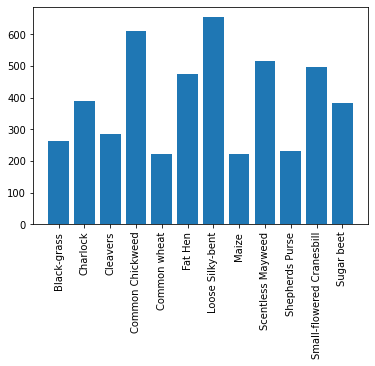

In [ ]:
# creating plot for distribution of images in each class
count_plot = np.array(count_plot)
plt.bar(labels, count_plot)
plt.xticks(rotation = 90)
plt.show()

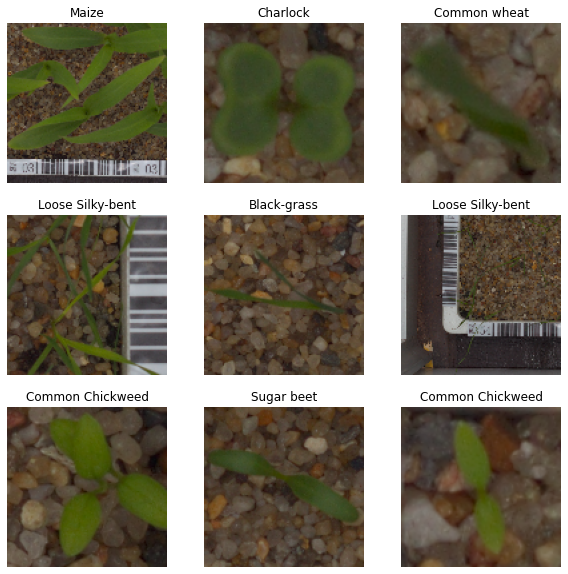

In [ ]:
# visualizing few images from the train data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image, label in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(labels[label[i]])
    plt.axis("off")

In [ ]:
#Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.
#Dataset.prefetch() overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating the model

### Model 1
Creating a CNN model, which can accurately detect 12 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [ ]:
# specifying image dimensions with RGB channel
input_shape = (120,120,3)
# storing number of classes of plant seedlings in a variable
num_classes = 12

# creating layers for the first model using conv2D
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0, input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
# using batch normalization
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
### Compiling the model
### choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
### Training the model
epochs = 20
batch_size = 32
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/20
119/119 [==============================] - 898s 2s/step - loss: 3.1958 - accuracy: 0.5211 - val_loss: 12.1155 - val_accuracy: 0.0484
Epoch 2/20
119/119 [==============================] - 6s 46ms/step - loss: 0.8424 - accuracy: 0.7434 - val_loss: 13.8074 - val_accuracy: 0.1463
Epoch 3/20
119/119 [==============================] - 6s 47ms/step - loss: 0.5283 - accuracy: 0.8353 - val_loss: 9.6304 - val_accuracy: 0.1189
Epoch 4/20
119/119 [==============================] - 6s 47ms/step - loss: 0.3021 - accuracy: 0.8953 - val_loss: 8.6649 - val_accuracy: 0.2053
Epoch 5/20
119/119 [==============================] - 6s 47ms/step - loss: 0.2253 - accuracy: 0.9242 - val_loss: 1.4898 - val_accuracy: 0.6568
Epoch 6/20
119/119 [==============================] - 6s 47ms/step - loss: 0.2187 - accuracy: 0.9247 - val_loss: 1.7026 - val_accuracy: 0.6674
Epoch 7/20
119/119 [==============================] - 6s 47ms/step - loss: 0.2464 - accuracy: 0.9187 - val_loss: 1.4249 - val_accuracy: 0.73

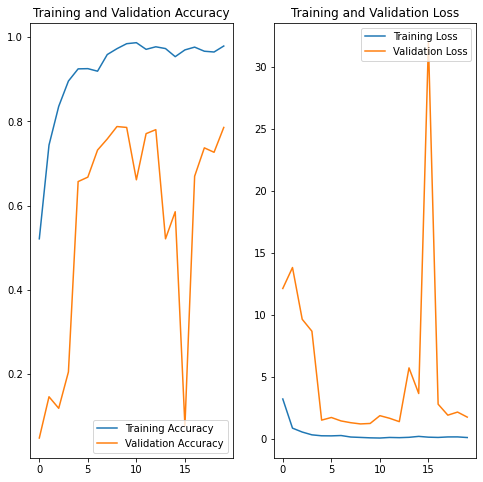

In [ ]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Results from Model 1
1. The accuracy of the model for the Training data set is at 97%. But the Validation accuracy is not in par with the training accuracy.
It is only at 78%. 
2. The validation loss (1.7326) as observed is very high.This could also be indicative of some Overfitting in the model.
3. We could add some Dropout layers and remove the BatchNormalization layers to avoid overfitting to some extent

### Model 2
#### Removing Batch Normalization and Adding Dropouts.
Removing Batch Normalization for this layer and adding dropouts after every hidden layer to avoid overfitting

In [ ]:
input_shape = (120,120,3)
num_classes = 12

model2 = Sequential()
# adding layers for normalizing the images between 0 and 1
model2.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0, input_shape=input_shape))
model2.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(32, kernel_size=(3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.50))

model2.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.50))

model2.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.50))

model2.add(Flatten())
model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(Dropout(0.50))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

In [ ]:
### compiling the model
### choosing an appropirate optimiser and loss function
opt = Adam(0.001) # specifying the optimizer used for the model
model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# specifying the format in which model needs to be saved
model_name = 'Seed2' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path       
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
### training the model and using callback parameter to save the best model
epochs = 50
batch_size = 32
history = model2.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/50
118/119 [============================>.] - ETA: 0s - loss: 2.4323 - accuracy: 0.1356
Epoch 1: val_loss improved from inf to 2.41547, saving model to Seed2/model-00001-2.43193-2.41547-.h5
119/119 [==============================] - 6s 44ms/step - loss: 2.4319 - accuracy: 0.1353 - val_loss: 2.4155 - val_accuracy: 0.1116
Epoch 2/50
119/119 [==============================] - ETA: 0s - loss: 2.4191 - accuracy: 0.1405
Epoch 2: val_loss improved from 2.41547 to 2.38316, saving model to Seed2/model-00002-2.41911-2.38316-.h5
119/119 [==============================] - 5s 42ms/step - loss: 2.4191 - accuracy: 0.1405 - val_loss: 2.3832 - val_accuracy: 0.1284
Epoch 3/50
119/119 [==============================] - ETA: 0s - loss: 2.2150 - accuracy: 0.2321
Epoch 3: val_loss improved from 2.38316 to 1.73099, saving model to Seed2/model-00003-2.21501-1.73099-.h5
119/119 [==============================] - 5s 42ms/step - loss: 2.2150 - accuracy: 0.2321 - val_loss: 1.7310 - val_accuracy: 0.4168
Ep

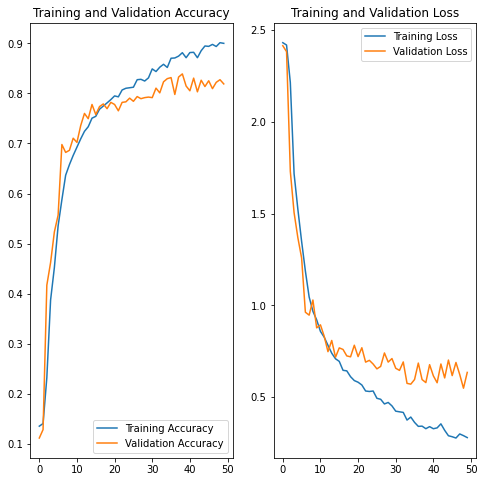

In [ ]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Results from Model 2
1. The model is performing better than the previous model since there is comparatively less overfitting.
2. Training accuracy of 90% and validation accuracy of 82%.
3. Early Stopping used.
4. Validation loss improved from 1.7 to 0.55

## Model 3 
#### Creating a model using data augmetation
1. layers.experimental.preprocessing.RandomFlip() - A preprocessing layer which randomly flips images during training.
2. layers.experimental.preprocessing.RandomRotation() - A preprocessing layer which randomly rotates images during training.

In [ ]:
input_shape = (120,120,3)
num_classes = 12

model_aug = Sequential()
# scaling the images
model_aug.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0))
#layers.experimental.preprocessing.RandomFlip() - A preprocessing layer which randomly flips images during training.
#layers.experimental.preprocessing.RandomRotation() - A preprocessing layer which randomly rotates images during training.
model_aug.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
model_aug.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
model_aug.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(Conv2D(32, kernel_size=(3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
# adding dropout layer after each Maxpooling layer
model_aug.add(Dropout(0.50))

model_aug.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(Conv2D(64, (3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Dropout(0.50))

model_aug.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(Conv2D(128, (3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Dropout(0.50))

model_aug.add(Flatten())
model_aug.add(Dense(512))
model_aug.add(Activation('relu'))
model_aug.add(Dropout(0.50))
model_aug.add(Dense(num_classes))
model_aug.add(Activation('softmax'))

In [ ]:
### compiling the augmented model
### choosing an appropirate optimiser and loss function
model_aug.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# spefying the format in which model needs to be saved
model_name = 'Seed3' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path       
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
### training the model
epochs = 100
batch_size = 32
history = model_aug.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True)

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 2.4375 - accuracy: 0.1292
Epoch 1: val_loss improved from inf to 2.41214, saving model to Seed3/model-00001-2.43753-2.41214-.h5
119/119 [==============================] - 5s 30ms/step - loss: 2.4375 - accuracy: 0.1292 - val_loss: 2.4121 - val_accuracy: 0.1463
Epoch 2/100
117/119 [============================>.] - ETA: 0s - loss: 2.1562 - accuracy: 0.2567
Epoch 2: val_loss improved from 2.41214 to 1.71589, saving model to Seed3/model-00002-2.15304-1.71589-.h5
119/119 [==============================] - 3s 29ms/step - loss: 2.1530 - accuracy: 0.2584 - val_loss: 1.7159 - val_accuracy: 0.3947
Epoch 3/100
118/119 [============================>.] - ETA: 0s - loss: 1.6418 - accuracy: 0.4329
Epoch 3: val_loss improved from 1.71589 to 1.54917, saving model to Seed3/model-00003-1.64098-1.54917-.h5
119/119 [==============================] - 4s 30ms/step - loss: 1.6410 - accuracy: 0.4326 - val_loss: 1.5492 - val_accuracy: 0.4905

In [ ]:
### summary of the above model
model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 120, 120, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 120, 120, 3)      0         
 tation)                                                         
                                                                 
 conv2d_12 (Conv2D)          (None, 120, 120, 32)      896       
                                                                 
 activation_16 (Activation)  (None, 120, 120, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 118, 118, 32)      9248      
                                                      

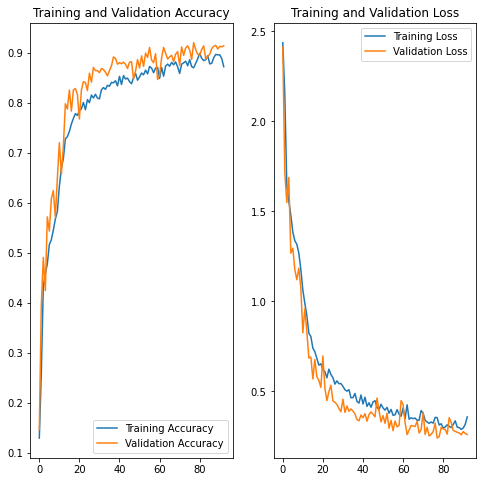

In [ ]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(93)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Results from Model 3
1. Including Data Augmentation has improved the model accuracy to 92% and also handled overfitting to great extent.
2. Data Augmentation has improved the model performance.
3. Validation loss have improved from 0.55 to 0.25

### Model 4

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
### defining the path for training and test images
train_path = "/content/gdrive/MyDrive/TMLC/plant-seedlings-classification/train/"
test_path = "/content/gdrive/MyDrive/TMLC/plant-seedlings-classification/test/"

In [ ]:
### distibution of classes for each category of data
### It can be seen that data has imbalances in the class distribution
for i in labels:
    directory =train_path + i + '/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.png')))
    print(f'{i} has {length} samples.')

Black-grass has 263 samples.
Charlock has 390 samples.
Cleavers has 287 samples.
Common Chickweed has 611 samples.
Common wheat has 221 samples.
Fat Hen has 475 samples.
Loose Silky-bent has 654 samples.
Maize has 221 samples.
Scentless Mayweed has 516 samples.
Shepherds Purse has 231 samples.
Small-flowered Cranesbill has 496 samples.
Sugar beet has 385 samples.


- Common wheat has least number of samples - 221
- Loose Silky-bent has maximum number of samples - 654

In [ ]:
# You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes 
# so that none of the classes have very few samples.
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [ ]:
path_to_training_dataset=train_path
import Augmentor
for i in labels:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 263 image(s) found.
Output directory set to /content/gdrive/MyDrive/TMLC/plant-seedlings-classification/train/Black-grass/output.

Processing <PIL.Image.Image image mode=RGB size=1328x1328 at 0x7F95A74A0950>: 100%|██████████| 500/500 [01:12<00:00,  6.85 Samples/s]


Initialised with 390 image(s) found.
Output directory set to /content/gdrive/MyDrive/TMLC/plant-seedlings-classification/train/Charlock/output.

Processing <PIL.Image.Image image mode=RGB size=124x124 at 0x7F95A74E77D0>: 100%|██████████| 500/500 [00:35<00:00, 14.12 Samples/s]


Initialised with 287 image(s) found.
Output directory set to /content/gdrive/MyDrive/TMLC/plant-seedlings-classification/train/Cleavers/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=140x140 at 0x7F95A74C9390>: 100%|██████████| 500/500 [00:15<00:00, 31.74 Samples/s]


Initialised with 611 image(s) found.
Output directory set to /content/gdrive/MyDrive/TMLC/plant-seedlings-classification/train/Common Chickweed/output.

Processing <PIL.Image.Image image mode=RGB size=112x112 at 0x7F95A74EB2D0>: 100%|██████████| 500/500 [00:09<00:00, 50.56 Samples/s] 


Initialised with 221 image(s) found.
Output directory set to /content/gdrive/MyDrive/TMLC/plant-seedlings-classification/train/Common wheat/output.

Processing <PIL.Image.Image image mode=RGB size=87x87 at 0x7F95A74CD910>: 100%|██████████| 500/500 [00:34<00:00, 14.41 Samples/s]


Initialised with 475 image(s) found.
Output directory set to /content/gdrive/MyDrive/TMLC/plant-seedlings-classification/train/Fat Hen/output.

Processing <PIL.Image.Image image mode=RGB size=145x145 at 0x7F95A74B3810>: 100%|██████████| 500/500 [00:16<00:00, 30.63 Samples/s]


Initialised with 654 image(s) found.
Output directory set to /content/gdrive/MyDrive/TMLC/plant-seedlings-classification/train/Loose Silky-bent/output.

Processing <PIL.Image.Image image mode=RGB size=116x116 at 0x7F95A74C7D90>: 100%|██████████| 500/500 [00:42<00:00, 11.85 Samples/s]


Initialised with 221 image(s) found.
Output directory set to /content/gdrive/MyDrive/TMLC/plant-seedlings-classification/train/Maize/output.

Processing <PIL.Image.Image image mode=RGB size=182x182 at 0x7F95A6092A90>: 100%|██████████| 500/500 [00:48<00:00, 10.22 Samples/s]


Initialised with 516 image(s) found.
Output directory set to /content/gdrive/MyDrive/TMLC/plant-seedlings-classification/train/Scentless Mayweed/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=390x390 at 0x7F95A60BAA90>: 100%|██████████| 500/500 [00:11<00:00, 45.07 Samples/s]


Initialised with 231 image(s) found.
Output directory set to /content/gdrive/MyDrive/TMLC/plant-seedlings-classification/train/Shepherds Purse/output.

Processing <PIL.Image.Image image mode=RGB size=87x87 at 0x7F95A74A3B90>: 100%|██████████| 500/500 [00:19<00:00, 25.31 Samples/s]


Initialised with 496 image(s) found.
Output directory set to /content/gdrive/MyDrive/TMLC/plant-seedlings-classification/train/Small-flowered Cranesbill/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=213x213 at 0x7F95AA48D490>: 100%|██████████| 500/500 [00:21<00:00, 23.67 Samples/s]


Initialised with 385 image(s) found.
Output directory set to /content/gdrive/MyDrive/TMLC/plant-seedlings-classification/train/Sugar beet/output.

Processing <PIL.Image.Image image mode=RGB size=999x937 at 0x7F95A607A550>: 100%|██████████| 500/500 [00:58<00:00,  8.57 Samples/s]


### The distribution of augmented data after adding new images to the original training data.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.png')))
print(image_count_train)

6000


In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.png'))]

In [ ]:
seed_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.png'))]

In [ ]:
dataframe_dict_new = dict(zip(path_list, seed_list_new))

In [ ]:
### Distribution of classes after augmentation
for i in labels:
    directory =train_path+i+'/'
    directory_out =train_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.png')))
    length_out=len(list(class_directory_out.glob('*.png')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

Black-grass has 763 samples.
Charlock has 890 samples.
Cleavers has 787 samples.
Common Chickweed has 1111 samples.
Common wheat has 721 samples.
Fat Hen has 975 samples.
Loose Silky-bent has 1154 samples.
Maize has 721 samples.
Scentless Mayweed has 1016 samples.
Shepherds Purse has 731 samples.
Small-flowered Cranesbill has 996 samples.
Sugar beet has 885 samples.


In [ ]:
batch_size = 32
img_height = 120
img_width = 120

### Training the model on the data created using Augmentor

### Create a training dataset

In [ ]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10750 files belonging to 12 classes.
Using 8600 files for training.


### Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10750 files belonging to 12 classes.
Using 2150 files for validation.


### Creating the model

In [ ]:
input_shape = (120,120,3)
num_classes = 12

model4 = Sequential()
model4.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0))
model4.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(32, kernel_size=(3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(64, (3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(128, (3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Flatten())
model4.add(Dense(256))
model4.add(Activation('relu'))
model4.add(Dropout(0.25))
model4.add(Dense(num_classes))
model4.add(Activation('softmax'))

### Compiling the model

In [ ]:
### choosing an appropirate optimiser and loss function
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Creating callbacks for changing the learning rate and also saving the best model

In [ ]:
# spefying the format in which model needs to be saved
model_name = 'Seed4' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path       
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models 
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=5, verbose=1, mode='max', min_lr=1e-5)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

callbacks_list = [checkpoint, early_stopping, lr_reduce]

In [ ]:
### training the model
epochs = 100
batch_size = 32
history = model4.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/100
267/269 [============================>.] - ETA: 0s - loss: 1.9697 - accuracy: 0.2897
Epoch 1: val_loss improved from inf to 1.15192, saving model to Seed4/model-00001-1.96535-1.15192-.h5
269/269 [==============================] - 68s 243ms/step - loss: 1.9653 - accuracy: 0.2912 - val_loss: 1.1519 - val_accuracy: 0.6009 - lr: 0.0010
Epoch 2/100
267/269 [============================>.] - ETA: 0s - loss: 0.9868 - accuracy: 0.6493
Epoch 2: val_loss improved from 1.15192 to 0.93623, saving model to Seed4/model-00002-0.98414-0.93623-.h5
269/269 [==============================] - 67s 243ms/step - loss: 0.9841 - accuracy: 0.6500 - val_loss: 0.9362 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 3/100
269/269 [==============================] - ETA: 0s - loss: 0.6379 - accuracy: 0.7709
Epoch 3: val_loss improved from 0.93623 to 0.49737, saving model to Seed4/model-00003-0.63789-0.49737-.h5
269/269 [==============================] - 66s 240ms/step - loss: 0.6379 - accuracy: 0.7709 - val_los

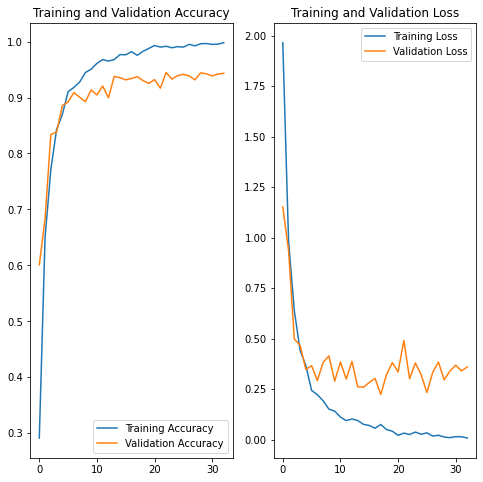

In [ ]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(33)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analysis of the result from Model 4
- Accuracy on validation data has increased to around 93.72% by using Augmentor library of Python
- Model is much less overfitting compared to previous models
- The above model can be further improved by tuning the hyperparameters.
- Validation loss has also improved to 0.22

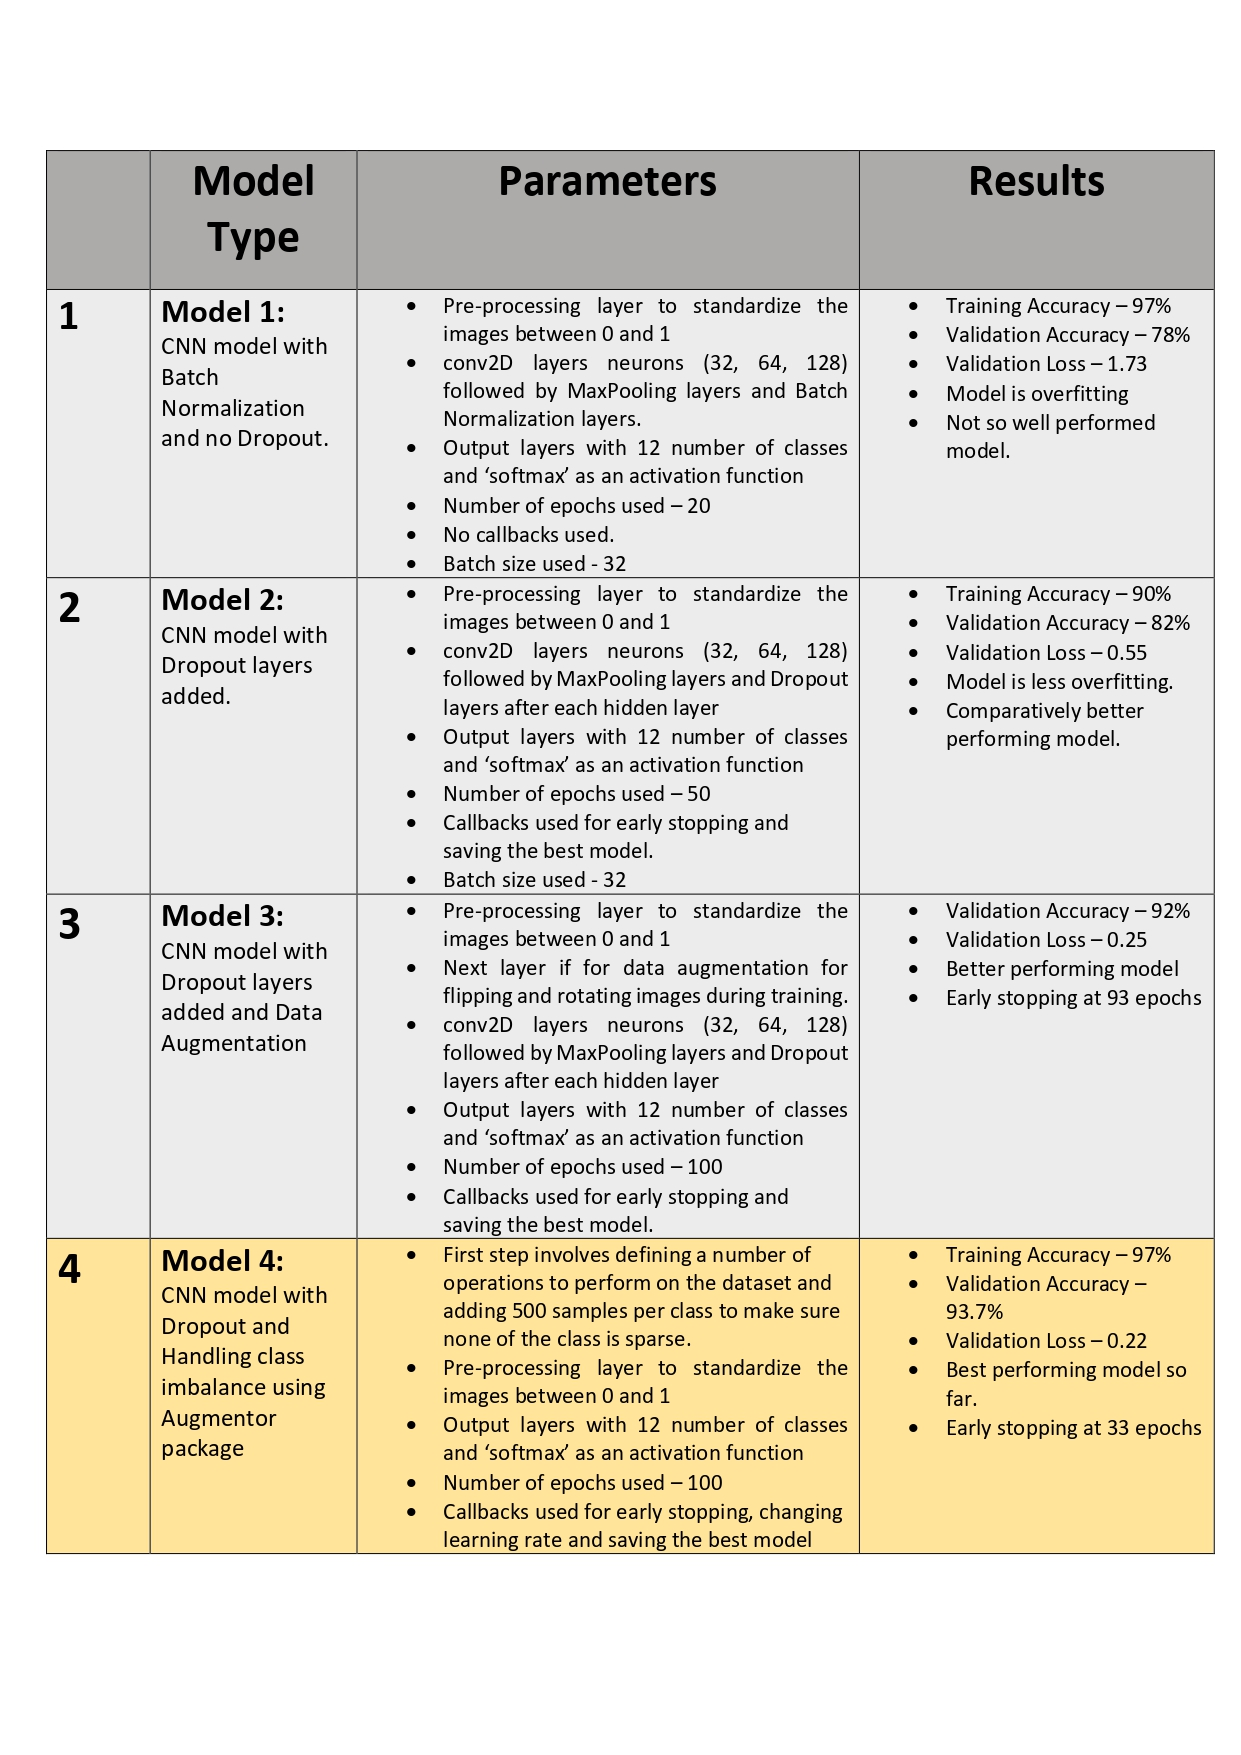